In [1]:
%autosave 300

Autosaving every 300 seconds


In [32]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

from jupyterthemes import jtplot
jtplot.style()

In [33]:
def create_boxplots(names, results):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot(111)
    plt.boxplot(results, whiskerprops={'color': '#987987', 'linewidth': 2}, boxprops={'color': '#987987', 'linewidth': 2}, medianprops={'color': '#789789', 'linewidth': 2}, capprops={'color': '#987987', 'linewidth': 2}, flierprops={'markeredgecolor': '#798798', 'linewidth': 2})
    ax.set_xticklabels(names)
    ax.tick_params(axis='x', colors='#ffffff')
    ax.tick_params(axis='y', colors='#ffffff')
    plt.show()
    
    
def print_results(res, names):
    print('best score', ':', res.fun, end='\n\n')
    for n, v in enumerate(names):
        print(v, ':', res.x[n])

In [34]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

df = pd.read_csv(url, names=names)

X = df.iloc[:, :8].values
y = df.iloc[:, 8].values

scl = StandardScaler()
X = scl.fit_transform(X)

n_features = X.shape[1]

print(df.shape)
df.head(2)

(768, 9)


,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


(array([500.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 268.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

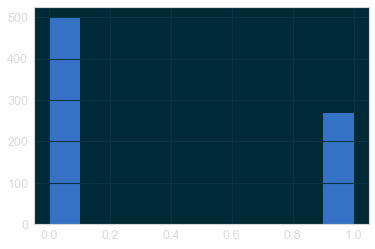

In [5]:
plt.hist(y)

In [40]:
models = [
    ('Log', LogisticRegression(max_iter=1000)),
    ('GB', GradientBoostingClassifier()),
    ('RF', RandomForestClassifier()),
    ('ET', ExtraTreesClassifier())
]

results = []
names = []

seed = 7
scoring = 'roc_auc'

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
    print("%s:\t%f (%f)" % (name, np.median(cv_results), cv_results.std()))

Log:	0.827002 (0.046555)
GB:	0.829075 (0.039599)
RF:	0.768455 (0.053762)
ET:	0.764360 (0.052822)


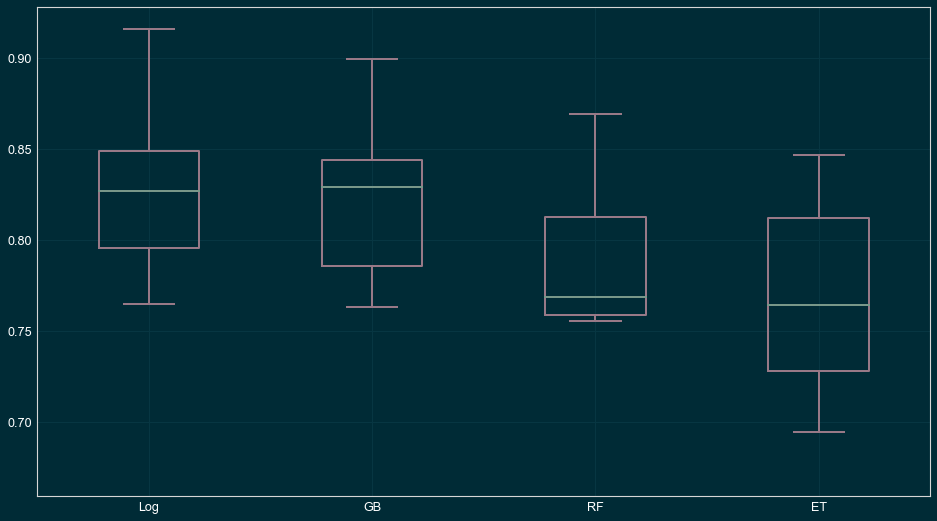

In [41]:
create_boxplots(names, results)

### logistic regression, l2

In [42]:
cls = LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l2')

space = [
    Categorical(['lbfgs', 'sag', 'saga', 'liblinear'], name='solver'),
    Real(1e-6, 1e-2, 'log_uniform', name='tol'),
    Real(.5, 2, name='C')
]

hp_names = ['solver', 'tol', 'C']

@use_named_args(space)
def objective(**params):
    cls.set_params(**params)
    
    return -np.mean(cross_val_score(cls, X, y, cv=5, n_jobs=-1, scoring=scoring))

res = gp_minimize(objective, space, n_calls=50, random_state=seed)

print_results(res, hp_names)

C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best score : -0.8331055206149547

solver : sag
tol : 0.008145724162957104
C : 0.5074331870466359


### logistic regression, l1

In [43]:
cls = LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1')

space = [
    Categorical(['liblinear', 'saga'], name='solver'),
    Real(1e-6, 1e-2, 'log_uniform', name='tol'),
    Real(.5, 2, name='C')
]

hp_names = ['solver', 'tol', 'C']

@use_named_args(space)
def objective(**params):
    cls.set_params(**params)
    
    return -np.mean(cross_val_score(cls, X, y, cv=5, n_jobs=-1, scoring=scoring))

res = gp_minimize(objective, space, n_calls=50, random_state=seed)

print_results(res, hp_names)

C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best score : -0.8329524807826694

solver : liblinear
tol : 0.009917289211245734
C : 1.9980583057482546


### gradient boosted

In [44]:
cls = GradientBoostingClassifier()

space = [
    Integer(1, 5, name='max_depth'),
    Integer(2, 100, name='min_samples_split'),
    Integer(1, 100, name='min_samples_leaf'),
    Integer(100, 1000, name='n_estimators'),
    Integer(1, n_features, name='max_features'),
    Real(1e-5, 1, 'log_uniform', name='learning_rate')
]

hp_names = ['max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators', 'max_features', 
            'learning_rate']

@use_named_args(space)
def objective(**params):
    cls.set_params(**params)
    return -np.mean(cross_val_score(cls, X, y, cv=5, n_jobs=-1, scoring=scoring))

res = gp_minimize(objective, space, n_calls=50, random_state=seed)

print_results(res, hp_names)

best score : -0.8439028651292804

max_depth : 1
min_samples_split : 100
min_samples_leaf : 1
n_estimators : 1000
max_features : 8
learning_rate : 0.04362018905455153


### random forest

In [48]:
cls = RandomForestClassifier()

space = [
    Integer(1, 5, name='max_depth'),
    Integer(2, 100, name='min_samples_split'),
    Integer(1, 100, name='min_samples_leaf'),
    Integer(100, 1000, name='n_estimators'),
    Integer(1, n_features, name='max_features'),
    Categorical(['gini', 'entropy'], name='criterion')
]

hp_names = ['max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators', 'max_features', 
            'criterion']

@use_named_args(space)
def objective(**params):
    cls.set_params(**params)
    return -np.mean(cross_val_score(cls, X, y, cv=5, n_jobs=-1, scoring=scoring))

res = gp_minimize(objective, space, n_calls=50, random_state=0)

print_results(res, hp_names)

C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best score : -0.8364353598881902

max_depth : 5
min_samples_split : 2
min_samples_leaf : 1
n_estimators : 1000
max_features : 5
criterion : entropy


### extra trees

In [49]:
cls = ExtraTreesClassifier()

space = [
    Integer(1, 5, name='max_depth'),
    Integer(2, 100, name='min_samples_split'),
    Integer(1, 100, name='min_samples_leaf'),
    Integer(100, 1000, name='n_estimators'),
    Integer(1, n_features, name='max_features'),
    Categorical(['gini', 'entropy'], name='criterion')
]

hp_names = ['max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators', 'max_features', 
            'criterion']

@use_named_args(space)
def objective(**params):
    cls.set_params(**params)
    return -np.mean(cross_val_score(cls, X, y, cv=5, n_jobs=-1, scoring=scoring))

res = gp_minimize(objective, space, n_calls=50, random_state=0)

print_results(res, hp_names)

C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best score : -0.8397875611460519

max_depth : 5
min_samples_split : 3
min_samples_leaf : 2
n_estimators : 472
max_features : 4
criterion : entropy


### compare

In [55]:
models = [
    ('Log', LogisticRegression(max_iter=1000, solver='sag', tol=0.00814572, C=0.507433)),
    ('GB', GradientBoostingClassifier(max_depth=1, min_samples_split=100, min_samples_leaf=1,
                                      n_estimators=1000, max_features=8, learning_rate=0.0436202)),
    ('RF', RandomForestClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=1, 
                                      n_estimators=1000, max_features=5, criterion='entropy')),
    ('ET', ExtraTreesClassifier(max_depth=5, min_samples_split=3, min_samples_leaf=2, 
                                      n_estimators=472, max_features=4, criterion='entropy'))
]

results = []
names = []

seed = 7
scoring = 'roc_auc'

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)

    print("%s:\t%f (%f)" % (name, np.median(cv_results), cv_results.std()))

Log:	0.826632 (0.046713)
GB:	0.834323 (0.032917)
RF:	0.832120 (0.041282)
ET:	0.836151 (0.040804)


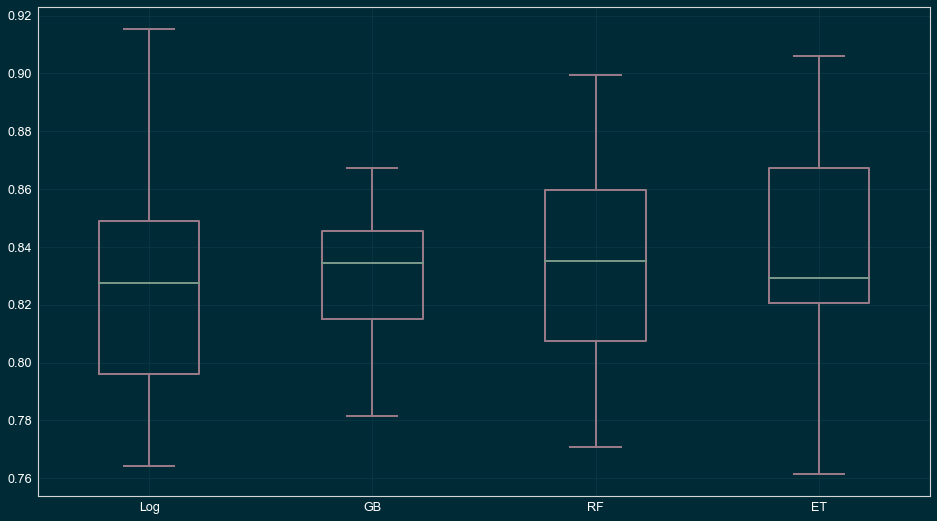

In [53]:
create_boxplots(names, results)